# import libraries

In [2]:
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.preprocessing  import StandardScaler
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pickle
from sklearn.metrics import ndcg_score

# import data

In [4]:
data = pd.read_csv('/home/darya/Загрузки/intern_task.csv')

In [5]:
data.sample(10)

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
133956,2,16915,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.200000,0.000000,0.000000,0.5,0.029412,0.000000,0.0,0.000000
94072,2,12250,3.0,0.0,1.0,0.0,3.0,1.0,0.000000,0.333333,...,0.0,0.000000,0.000000,0.998202,10.222280,0.0,0.028881,0.000003,23.0,7.666667
169854,0,20830,3.0,1.0,1.0,0.0,3.0,1.0,0.333333,0.333333,...,38.0,67.189286,0.000000,0.996112,6.749230,0.0,0.002864,0.000000,17.0,5.666667
158046,0,19555,3.0,0.0,0.0,0.0,3.0,1.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.413342,0.000000,0.0,0.010349,0.000054,91.0,30.333333
131016,1,16525,2.0,2.0,2.0,0.0,2.0,1.0,1.000000,1.000000,...,13.0,23.140000,0.000000,0.963914,10.666942,0.0,0.013588,0.000018,45.0,22.500000
113138,1,14470,3.0,0.0,1.0,0.0,3.0,1.0,0.000000,0.333333,...,1.0,66.000000,0.000000,0.693305,5.908467,0.0,0.030460,0.000923,175.0,58.333333
215962,2,26770,2.0,0.0,2.0,0.0,2.0,1.0,0.000000,1.000000,...,0.0,0.000000,0.000000,0.999709,43.827322,0.0,0.096582,0.000009,124.0,62.000000
218721,0,27205,1.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.000000,...,0.0,0.000000,0.111111,1.000000,16.022785,1.0,0.028640,0.000000,10.0,10.000000
163381,0,20035,1.0,0.0,1.0,1.0,1.0,1.0,0.000000,1.000000,...,1.0,17.000000,0.142857,1.000000,10.690044,1.0,0.057159,0.000000,101.0,101.000000
143319,1,17905,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.000000,...,6.0,31.466667,0.142857,0.000000,0.000000,1.0,0.001727,0.000000,0.0,0.000000


In [6]:
data.loc[data['query_id'] == 10]['rank'].value_counts()

rank
0    46
1    32
2    10
4     3
3     1
Name: count, dtype: int64

In [7]:
data.describe()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
count,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,...,2.352580e+05,2.352580e+05,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000,235258.000000
mean,0.677869,14828.413401,1.911960,0.206233,1.189847,0.550272,1.960082,0.803964,0.097557,0.541174,...,4.763432e+02,1.046698e+04,0.070299,0.740710,11.067947,0.281747,0.027033,0.000269,22.457910,9.560379
std,0.830033,8193.945170,1.237374,0.579089,1.037233,0.790947,1.203534,0.339955,0.266035,0.419973,...,1.954840e+04,2.649584e+06,0.100721,0.352800,15.336861,0.392089,0.033351,0.002088,63.708018,14.347378
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,8215.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.620522,0.000000,0.000000,0.006703,0.000000,4.000000,2.000000
50%,0.000000,14935.000000,2.000000,0.000000,1.000000,0.000000,2.000000,1.000000,0.000000,0.500000,...,0.000000e+00,0.000000e+00,0.000000,0.926779,9.448900,0.000000,0.017761,0.000008,12.000000,5.500000
75%,1.000000,21580.000000,3.000000,0.000000,2.000000,1.000000,3.000000,1.000000,0.000000,1.000000,...,1.000000e+00,4.000000e-01,0.142857,0.999613,16.146733,0.500000,0.034954,0.000109,28.000000,12.000000
max,4.000000,29995.000000,31.000000,18.000000,27.000000,9.000000,31.000000,1.000000,1.000000,1.000000,...,1.731553e+06,8.000000e+08,0.818182,1.000000,2506.799764,1.000000,0.711261,0.250000,15074.000000,1552.000000


In [8]:
data.isnull().sum().sum()

0

In [9]:
data.query_id.unique().shape

(2000,)

# work with data

In [10]:
new_data = data.drop(columns = ['feature_8', 'feature_100', 'feature_65', 'feature_20', 'feature_35', 'feature_64', 'feature_72'])

In [11]:
cat_features = ['feature_95', 'feature_96', 'feature_97', 'feature_98', 'feature_99']

In [12]:
cat_data = new_data[cat_features]
y = new_data['rank']

In [13]:
num_features = new_data.drop(columns=cat_features)
num_features = num_features.drop(columns=['rank'])

In [ ]:
for column in cat_data.columns.to_list():
    cat_data[column] = cat_data[column].astype('category')

# try to delete extreme

In [15]:
def clear_from_extreme(data):
    data_log = data.apply(lambda x:x if x == 0 else np.log(x))
    data_std = np.std(data_log)
    data_mean = np.mean(data_log)
    three_std_plus = data_mean + 2*data_std
    three_std_minus = data_mean - 2*data_std
    new_data = data_log.apply(lambda x: x if x < three_std_plus else three_std_plus)
    new_data = new_data.apply(lambda x: x if x > three_std_minus else three_std_minus)
    return new_data

In [16]:
num_features_log = num_features.apply(clear_from_extreme, axis=0)

# fit model

In [17]:
scaler = StandardScaler()
scaled_num_features = scaler.fit_transform(num_features)

In [18]:
new_data['qid'] = new_data['query_id']
new_data = new_data.drop(columns=['query_id'])

In [19]:
cleared_data_scaled = pd.concat([pd.DataFrame(scaled_num_features), cat_data, new_data['qid']], axis=1)
cleared_data = pd.concat([pd.DataFrame(num_features), cat_data, new_data['qid']], axis=1)

In [20]:
cleared_data_test = cleared_data.drop(columns=['feature_48'])

In [21]:
kfold = StratifiedGroupKFold(shuffle=False)
ranker_scaled = xgb.XGBRanker(tree_method="hist", lambdarank_num_pair_per_sample=150, objective="rank:ndcg", lambdarank_pair_method="mean", enable_categorical=True)
ranker_scaled.fit(cleared_data_scaled, y)
scaled_cvs = cross_val_score(ranker_scaled, cleared_data_scaled, y, cv=kfold, groups=cleared_data_scaled.qid)
np.mean(scaled_cvs)

0.7270545897250926

In [22]:
ranker_test = xgb.XGBRanker(tree_method="hist", lambdarank_num_pair_per_sample=150, objective="rank:ndcg", lambdarank_pair_method="mean", enable_categorical=True)
ranker_test.fit(cleared_data_test, y)
sel_cvs = cross_val_score(ranker_test, cleared_data_test, y, cv=kfold, groups=cleared_data_test.qid)
np.mean(sel_cvs)

0.7288241916214426

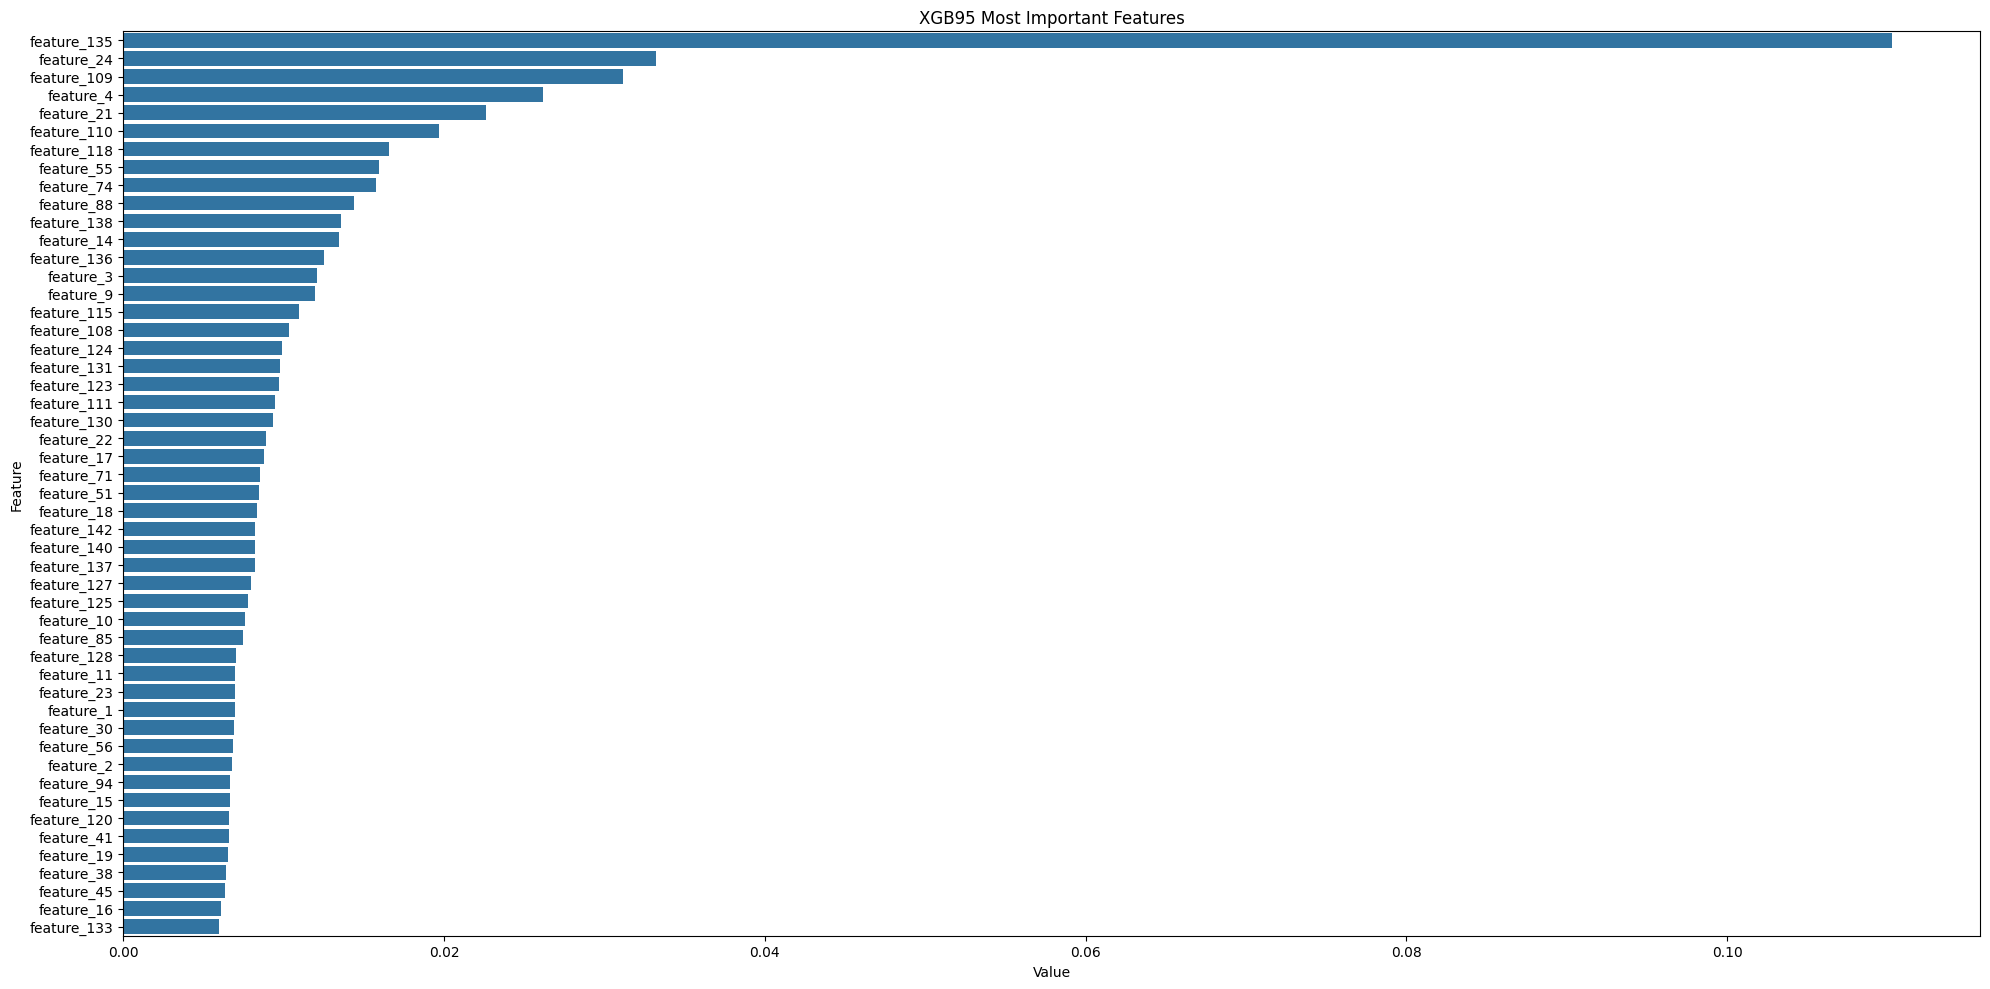

In [104]:
feature_imp=pd.DataFrame(sorted(zip(ranker_test.feature_importances_,cleared_data_test.columns.values[1:-1])), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()

## kendalltau

In [23]:
from scipy.stats import kendalltau

In [26]:
data_slice = cleared_data_test.loc[cleared_data_test['qid'].isin(cleared_data_test['qid'].unique()[:10])]

In [29]:
preds = ranker_test.predict(data_slice)

In [35]:
y_slice = y[:data_slice.shape[0]]

In [37]:
kendalltau(y_slice, preds).statistic

0.37832016846857824